In [1]:
import numpy as np
import pandas as pd
import geopandas
from math import sin, cos, asin, acos, radians

import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
FRACTION_DEMAND = 80    # Fraction of citizens of a city that may order a product  

# List of the 16 regions of germany
REGION_LIST = [
    'Berlin', 'Baden-Württemberg', 'Bavaria', 'Hamburg', 'North Rhine-Westphalia', 'Hesse', 'Saxony', 
    'Bremen', 'Lower Saxony', 'Schleswig-Holstein', 'Saxony-Anhalt', 'Rhineland-Palatinate', 'Thuringia', 'Brandenburg',
    'Saarland', 'Mecklenburg-Western Pomerania']


# Create the warehouses dataframe:
customer_df = pd.read_csv(
            './customer.csv', 
            usecols = ['city', 'lat', 'lng', 'population', 'capital', 'admin_name', 'gdp'])


# Customers IDs list
customer_df['customer_id'] = range(1, 1 + customer_df.shape[0])

# Create the customers dataframe:
#facility_df = df.\
#               loc[df.admin_name.isin(REGION_LIST)].\
#               sample(frac=FRACTION_CUSTOMERS, random_state=RANDOM_STATE, ignore_index=True)


# Demand is composed of: 
#   1. A fraction of the population
#   2. An error term of uniform distribution
# Note: demand is approximated to the closest int 
# as its physical meaning denies decimals
customer_df['ratio'] = (FRACTION_DEMAND * customer_df['gdp'])/47000

customer_df['demand'] = 0.2*np.floor(
    customer_df['ratio'] * customer_df.population + np.random.uniform(-10, 10, size=(customer_df.shape[0],)))

print(customer_df)

             city      lat      lng              admin_name capital  \
0       Nuremberg  49.4539  11.0775                 Bavaria   minor   
1          Munich  48.1375  11.5750                 Bavaria   admin   
2   Gelsenkirchen  51.5167   7.1000  North Rhine-Westphalia   minor   
3       Wuppertal  51.2667   7.1833  North Rhine-Westphalia   minor   
4         Münster  51.9625   7.6256  North Rhine-Westphalia   minor   
..            ...      ...      ...                     ...     ...   
56           Bonn  50.7333   7.1000  North Rhine-Westphalia   minor   
57     Kronshagen  54.3333  10.0833      Schleswig-Holstein     NaN   
58        Leipzig  51.3400  12.3750                  Saxony   minor   
59    Ludwigsburg  48.8975   9.1922       Baden-Württemberg   minor   
60      Esslingen  48.7333   9.3167       Baden-Württemberg   minor   

    population    gdp  customer_id       ratio      demand  
0       515543  60711            1  103.337872  10655022.6  
1      2606021  79690    

In [3]:
# Create the warehouses dataframe:
salt_df = pd.read_csv(
            './salt_locations.csv', 
            usecols = ['city', 'lat', 'lng', 'capacity_kg', 'investment_costs', 'admin_name'])


# Customers IDs list
salt_df['salt_id'] = range(1, 1 + salt_df.shape[0])
print(salt_df)

             city      lat       lng              admin_name  capacity_kg  \
0             Epe  52.1417   7.05110  North Rhine-Westphalia  91423728.81   
1          Xanten  51.6572   6.45970  North Rhine-Westphalia  91423728.81   
2    Bremen-Lesum  53.2144   8.64670                  Bremen  50428167.88   
3           Etzel  53.3894   7.55920            Lower Saxony  50428167.88   
4       Harsefeld  53.4403   9.47770            Lower Saxony  50428167.88   
5        Huntdorf  53.1231   7.86230            Lower Saxony  50428167.88   
6          Jemgum  53.2186   7.31220            Lower Saxony  50428167.88   
7       Krummhörn  53.3539   7.11920            Lower Saxony  50428167.88   
8      Nüttermoor  53.2196   7.11450            Lower Saxony  50428167.88   
9        Bernburg  51.7956  11.72560           Saxony-Anhalt  45711864.41   
10      Straßfurt  51.8328  11.55480           Saxony-Anhalt  45711864.41   
11  Bad Lachstädt  51.4843  11.74177           Saxony-Anhalt  45711864.41   

In [4]:
def add_geocoordinates(df, lat='lat', lng='lng'):
    '''
    Add column "geometry" with <shapely.geometry.point.Point> objects 
        built from latitude and longitude values in the input dataframe
    
    Args:
        - df: input dataframe
        - lat: name of the column containing the latitude (default: lat)
        - lng: name of the column containing the longitude (default: lng)
    Out:
        - df: same dataframe enriched with a geo-coordinate column
    '''
    assert pd.Series([lat, lng]).isin(df.columns).all(),\
        f'Cannot find columns "{lat}" and/or "{lng}" in the input dataframe.'
    return geopandas.GeoDataFrame(
        df, geometry=geopandas.points_from_xy(df.lng, df.lat))


customer_df = add_geocoordinates(customer_df)
salt_df = add_geocoordinates(salt_df)

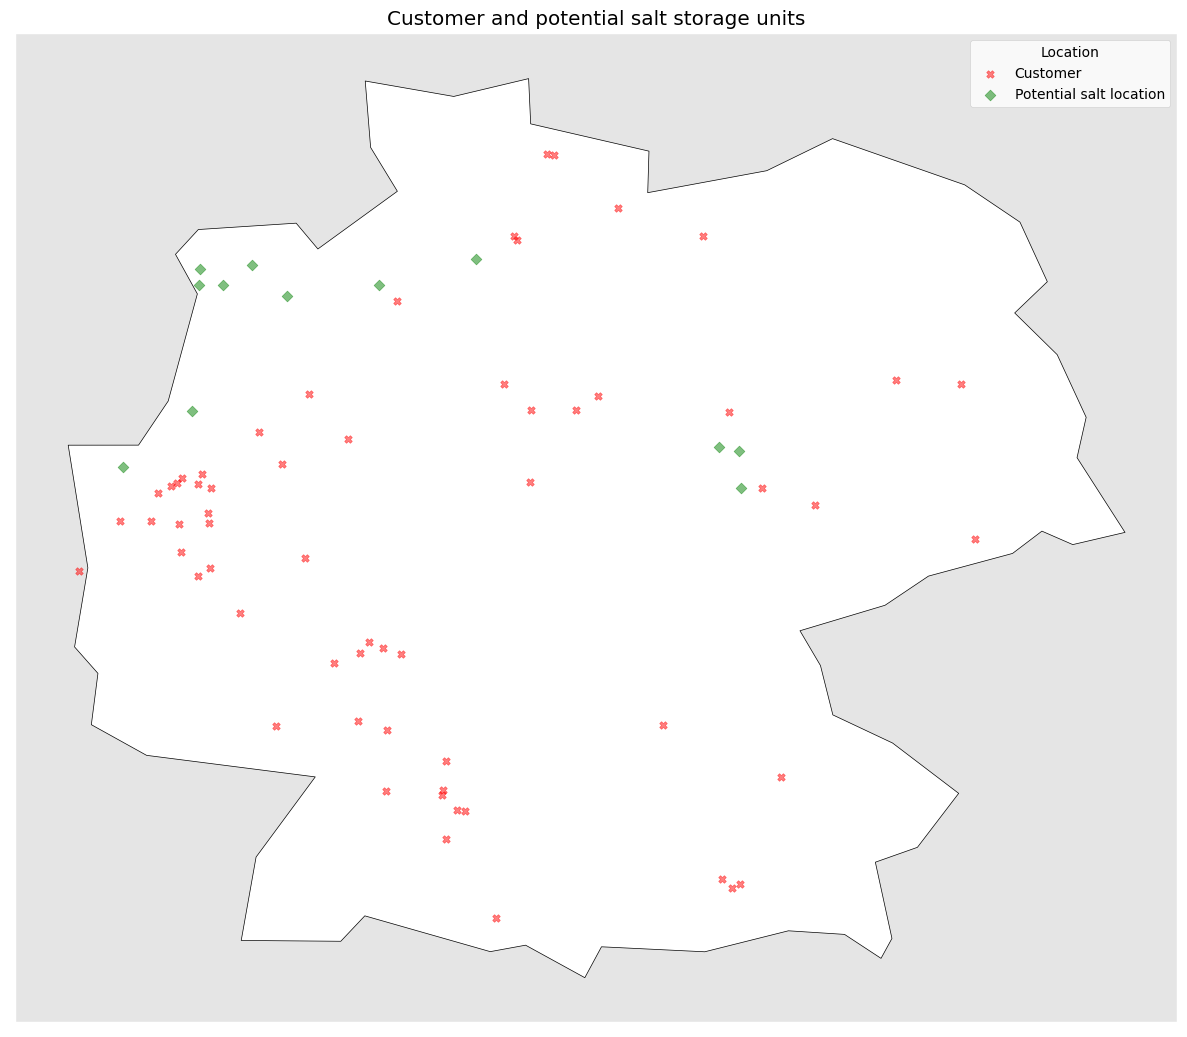

In [5]:
# Prepare country plot
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Extract and plot the shape of Germany
germany = world[world.name == 'Germany']
ax = germany.plot(color='white', edgecolor='black', figsize=(15, 15))

# Plot customers as points
customer_df.\
    plot(ax=ax, marker='X', color='red', markersize=30, alpha=0.5, label='Customer')

# Plot potential facility locations as points
salt_df.\
    plot(ax=ax, marker='D', color='green', markersize=30, alpha=0.5, label='Potential salt location')

# Add legend
plt.legend(facecolor='white', title='Location')

# Add title
plt.title('Customer and potential salt storage units')

# Remove ticks from axis
plt.xticks([])
plt.yticks([])

# Show plot
plt.show()

In [6]:
# Dictionary of cutomer id (id) and demand (value)
demand_dict = { customer : customer_df['demand'][i] for i, customer in enumerate(customer_df['customer_id']) }

In [7]:
# Warehouses list
salt_df['salt_id'] = ['Salt cavern ' + str(i) for i in range(1, 1 + salt_df.shape[0])]

# Dictionary of warehouse id (id) and max supply (value)
annual_supply_dict = { salt : salt_df['capacity_kg'][i] for i, salt in enumerate(salt_df['salt_id']) }

# Dictionary of warehouse id (id) and fixed costs (value)
annual_cost_dict = { salt : salt_df['investment_costs'][i] for i, salt in enumerate(salt_df['salt_id']) }

In [8]:
print(annual_supply_dict)
print(annual_cost_dict)

{'Salt cavern 1': 91423728.81, 'Salt cavern 2': 91423728.81, 'Salt cavern 3': 50428167.88, 'Salt cavern 4': 50428167.88, 'Salt cavern 5': 50428167.88, 'Salt cavern 6': 50428167.88, 'Salt cavern 7': 50428167.88, 'Salt cavern 8': 50428167.88, 'Salt cavern 9': 50428167.88, 'Salt cavern 10': 45711864.41, 'Salt cavern 11': 45711864.41, 'Salt cavern 12': 45711864.41}
{'Salt cavern 1': 569492, 'Salt cavern 2': 569492, 'Salt cavern 3': 314124, 'Salt cavern 4': 314124, 'Salt cavern 5': 314124, 'Salt cavern 6': 314124, 'Salt cavern 7': 314124, 'Salt cavern 8': 314124, 'Salt cavern 9': 314124, 'Salt cavern 10': 284746, 'Salt cavern 11': 284746, 'Salt cavern 12': 284746}


In [9]:
import networkx as nx
from geopy.distance import distance
import heapq


# Function to find the location of a specific city
def find_city_location(city_name, city_data):
    # Check if the city exists in the city database
    if city_name in city_data['city'].values:
        # Get the latitude and longitude values for the city
        city_row = city_data[city_data['city'] == city_name].iloc[0]
        city_lat = city_row['lat']
        city_lng = city_row['lng']

        # Find the closest node in the graph
        closest_node = None
        min_distance = float('inf')

        # Iterate over each node in the graph
        for node in G.nodes():
            # Get the latitude and longitude values for the node
            node_lat = G.nodes[node]['lat']
            node_lng = G.nodes[node]['long']

            # Calculate the distance between the node and the city using geopy
            node_location = (node_lat, node_lng)
            city_location = (city_lat, city_lng)
            node_distance = distance(node_location, city_location).km

            # Update the closest node if a shorter distance is found
            if node_distance < min_distance:
                min_distance = node_distance
                closest_node = node

        return closest_node
    else:
        return 'City not found in the city database'



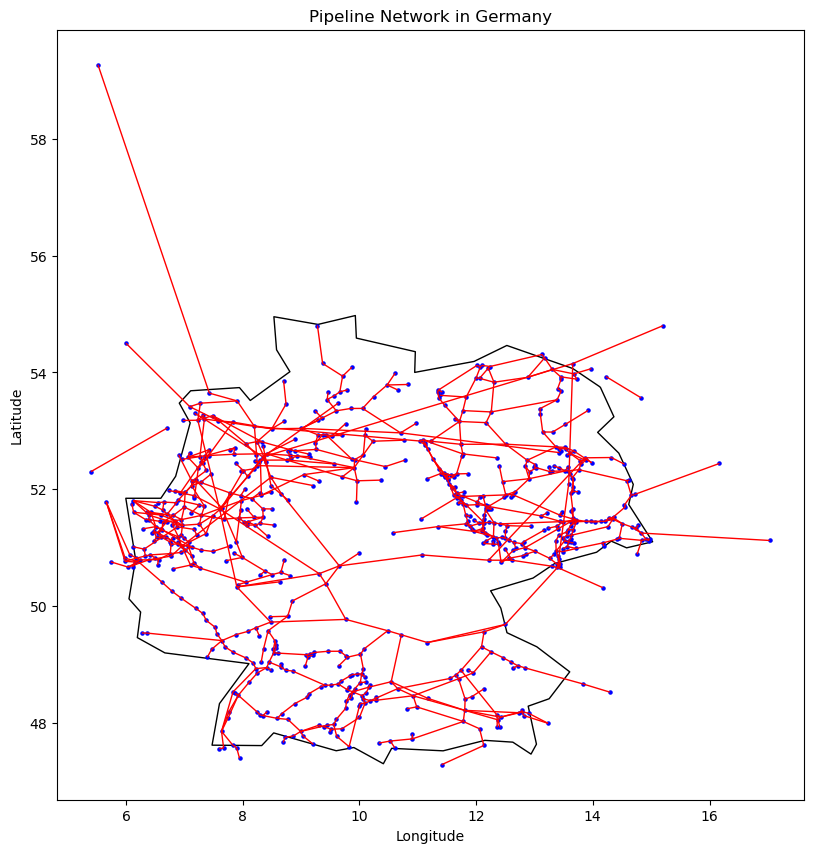

In [5]:

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
import networkx as nx
from geopy.distance import distance
import matplotlib.pyplot as plt


# Read the pipeline data from a CSV file
pipeline_data = pd.read_csv('LKD_PipeSegments.csv', delimiter=';', usecols=['name', 'node_id', 'lat', 'long'])

# Create an empty graph
G = nx.Graph()

# Iterate over each row in the pipeline data
for index, row in pipeline_data.iterrows():
    node_ids = row['node_id'][1:-1].split(', ')
    latitudes = row['lat'][1:-1].split(', ')
    longitudes = row['long'][1:-1].split(', ')

    # Iterate over each node ID, latitude, and longitude pair
    for i in range(len(node_ids)):
        node_id = node_ids[i][1:-1]  # Remove the square brackets from the node ID
        latitude = float(latitudes[i])
        longitude = float(longitudes[i])

        # Check if the node already exists in the graph
        if not G.has_node(node_id):
            # Add the node to the graph
            G.add_node(node_id)

        # Set latitude and longitude as node attributes
        G.nodes[node_id]['lat'] = latitude
        G.nodes[node_id]['long'] = longitude

        # Calculate the distance between the current node and the next node
        if i < len(node_ids) - 1:
            next_node_id = node_ids[i + 1][1:-1]  # Remove the square brackets from the next node ID
            next_latitude = float(latitudes[i + 1])
            next_longitude = float(longitudes[i + 1])

            # Calculate the distance between the current node and the next node using latitude and longitude
            node_distance = distance((latitude, longitude), (next_latitude, next_longitude)).kilometers

            # Add an edge between the current node and the next node with the distance as an attribute
            G.add_edge(node_id, next_node_id, distance=node_distance)

            # Create a GeoDataFrame from the node attributes in the graph
nodes_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index', columns=['lat', 'long'])
geometry = gpd.points_from_xy(nodes_df['long'], nodes_df['lat'])
nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry=geometry)

# Create a GeoDataFrame from the edges in the graph
edges_data = []
lines = []
for u, v, data in G.edges(data=True):
    source = nodes_gdf.loc[u, 'geometry']
    target = nodes_gdf.loc[v, 'geometry']
    line = LineString([source, target])
    lines.append(line)
    edges_data.append((u, v, data['distance']))

edges_df = pd.DataFrame(edges_data, columns=['source', 'target', 'distance'])
edges_gdf = gpd.GeoDataFrame(edges_df, geometry=lines)

# Plot the graph
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
germany = world[world['name'] == 'Germany']
fig, ax = plt.subplots(figsize=(10, 10))
germany.plot(ax=ax, color='white', edgecolor='black')
edges_gdf.plot(ax=ax, color='red', linewidth=1)
nodes_gdf.plot(ax=ax, color='blue', markersize=5)
plt.title('Pipeline Network in Germany')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()



In [3]:
def calculate_distance(city1_name, database_1, city2_name, database_2):
    closest_node1 = find_city_location(city1_name, database_1)
    closest_node2 = find_city_location(city2_name, database_2)

    shortest_path = nx.shortest_path(G, closest_node1, closest_node2, weight='distance')

    total_distance = sum(G.edges[u, v]['distance'] for u, v in zip(shortest_path[:-1], shortest_path[1:]))

    return total_distance

In [12]:
def traveling_cost(distance_in_km):
    '''
    Return traveling cost in euros given a distance in Km.

    Args:
      - distance_in_km: travel distance in Km
    Out:
      - cost of the trip in euros
    '''
    return 0.25 * distance_in_km

In [13]:
# Dict to store the distances between all salt location and customers
transport_costs_dict = {}

# For each warehouse location
for i in range(0, salt_df.shape[0]):
    
    # Dict to store the distances between the i-th salt location and all customers
    warehouse_transport_costs_dict = {}
    
    # For each customer location
    for j in range(0, customer_df.shape[0]):
        
        # Distance in Km between warehouse i and customer j
        d = 0 if salt_df.city[i]==customer_df.city[j] else calculate_distance(salt_df.city[i], salt_df, customer_df.city[j], customer_df)
        
        # Update costs for warehouse i
        warehouse_transport_costs_dict.update({customer_df.customer_id[j]: traveling_cost(d)})
    
    # Final dictionary with all costs for all warehouses
    print(warehouse_transport_costs_dict)
    transport_costs_dict.update({salt_df.salt_id[i]: warehouse_transport_costs_dict})

{1: 168.17074771303024, 2: 196.29315847457303, 3: 18.812151743782643, 4: 29.185930512752016, 5: 12.48554873997145, 6: 132.54578253366859, 7: 135.60982460099885, 8: 29.899556653022817, 9: 18.9400819853161, 10: 141.74683433834454, 11: 153.46645888245433, 12: 128.19929648692943, 13: 148.53865271465037, 14: 43.6272156999862, 15: 33.35398234201245, 16: 145.30569622723348, 17: 48.39678117237817, 18: 67.25169695221263, 19: 146.8061677385035, 20: 47.910994277378066, 21: 135.60982460099885, 22: 200.309017680579, 23: 27.56191444848614, 24: 147.0409875387948, 25: 18.812151743782643, 26: 91.62636693314204, 27: 70.67522665428642, 28: 39.00922815327132, 29: 18.9400819853161, 30: 135.60982460099885, 31: 200.43064316122022, 32: 88.45252735830502, 33: 44.58315331071789, 34: 34.241856127971225, 35: 77.54341239836222, 36: 116.72587725923097, 37: 200.309017680579, 38: 37.3527607295391, 39: 171.8535084586326, 40: 42.569542394153714, 41: 80.69294219853275, 42: 102.23907951578111, 43: 132.6133447928432, 44: 

In [14]:
## Create a new model
model = gp.Model('CFLP')

# Variable: y_j (constraint: it is binary)
created_facility = {}
for j in salt_df['salt_id']:
    created_facility[j] = model.addVar(vtype=GRB.BINARY, name=f'Create_facility_{j}')

# Variable: x_ij
served_customer = {}
for i in customer_df['customer_id']:
    for j in salt_df['salt_id']:
        served_customer[(i, j)] = model.addVar(lb=0, name=f'Link_{i}_{j}')

# Objective function
objective = gp.quicksum(annual_cost_dict[j] * created_facility[j] for j in salt_df['salt_id']) + \
            gp.quicksum(transport_costs_dict[j][i] * served_customer[(i, j)] for j in salt_df['salt_id'] for i in customer_df['customer_id'])
model.setObjective(objective, GRB.MINIMIZE)

# Constraint: the demand must be met
for i in customer_df['customer_id']:
    model.addConstr(gp.quicksum(served_customer[(i, j)] for j in salt_df['salt_id']) == demand_dict[i])

# Constraint: a warehouse cannot deliver more than its capacity limit
for j in salt_df['salt_id']:
    model.addConstr(gp.quicksum(served_customer[(i, j)] for i in customer_df['customer_id']) <= annual_supply_dict[j] * created_facility[j])

# Constraint: a warehouse cannot give a customer more than its demand
for i in customer_df['customer_id']:
    for j in salt_df['salt_id']:
        model.addConstr(served_customer[(i, j)] <= demand_dict[i] * created_facility[j])

# Optimize the model
model.optimize()


Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-06
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 5 PRO 5650U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 805 rows, 744 columns and 2940 nonzeros
Model fingerprint: 0xbbb67f6c
Variable types: 732 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+07]
  Objective range  [6e+00, 6e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+04, 7e+07]
Found heuristic solution: objective 3.360860e+10
Presolve time: 0.00s
Presolved: 805 rows, 744 columns, 2940 nonzeros
Variable types: 732 continuous, 12 integer (12 binary)

Root relaxation: objective 2.034488e+10, 18 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbe

In [15]:
# Create dataframe column to store whether to build the warehouse or not
salt_df['build_warehouse'] = ''

# Assign Yes/No to the dataframe column based on the optimization binary variable
for i in salt_df['salt_id']:
    if created_facility[i].X == 1:
        print('Build site at: ', i)
        salt_df.loc[salt_df['salt_id'] == i, 'build_warehouse'] = 'Yes'
    else:
        salt_df.loc[salt_df['salt_id'] == i, 'build_warehouse'] = 'No'

Build site at:  Salt cavern 1
Build site at:  Salt cavern 2
Build site at:  Salt cavern 3
Build site at:  Salt cavern 5
Build site at:  Salt cavern 9
Build site at:  Salt cavern 10
Build site at:  Salt cavern 11
Build site at:  Salt cavern 12


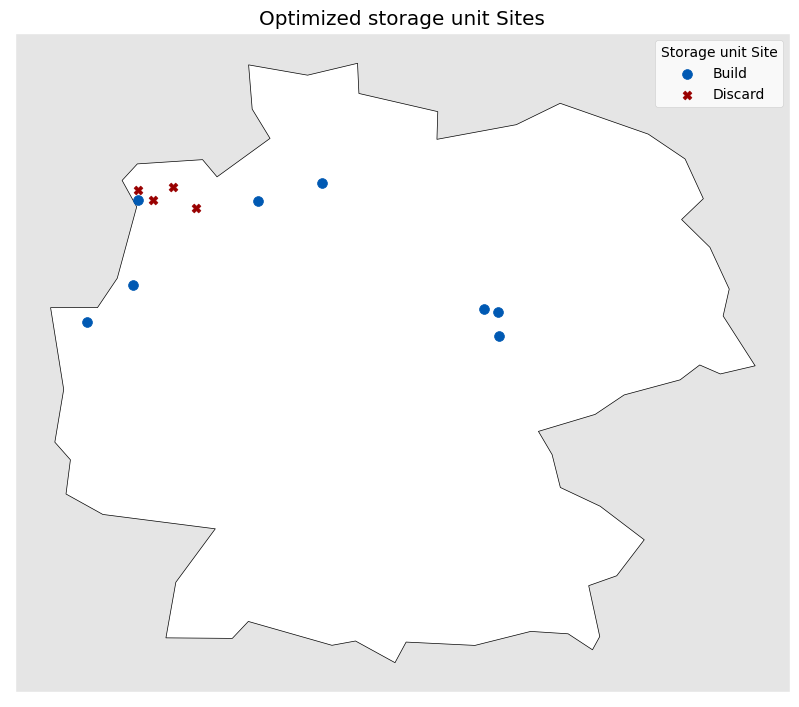

In [16]:
# Plot the shape of germany
ax = germany.plot(color='white', edgecolor='black', figsize=(10, 10))

# Plot sites to establish
salt_df.\
    loc[salt_df.build_warehouse =='Yes'].\
    plot(ax=ax, marker='o', c='#0059b3', markersize=50, label='Build')

# Plot sites to discard
salt_df.\
    loc[salt_df.build_warehouse =='No'].\
    plot(ax=ax, marker='X', c='#990000', markersize=40, label='Discard')

# Add title
plt.title('Optimized storage unit Sites')

# Add legend
plt.legend(title='Storage unit Site', facecolor='white')

# Remove ticks from axis
plt.xticks([])
plt.yticks([])


# Show plot
plt.show()

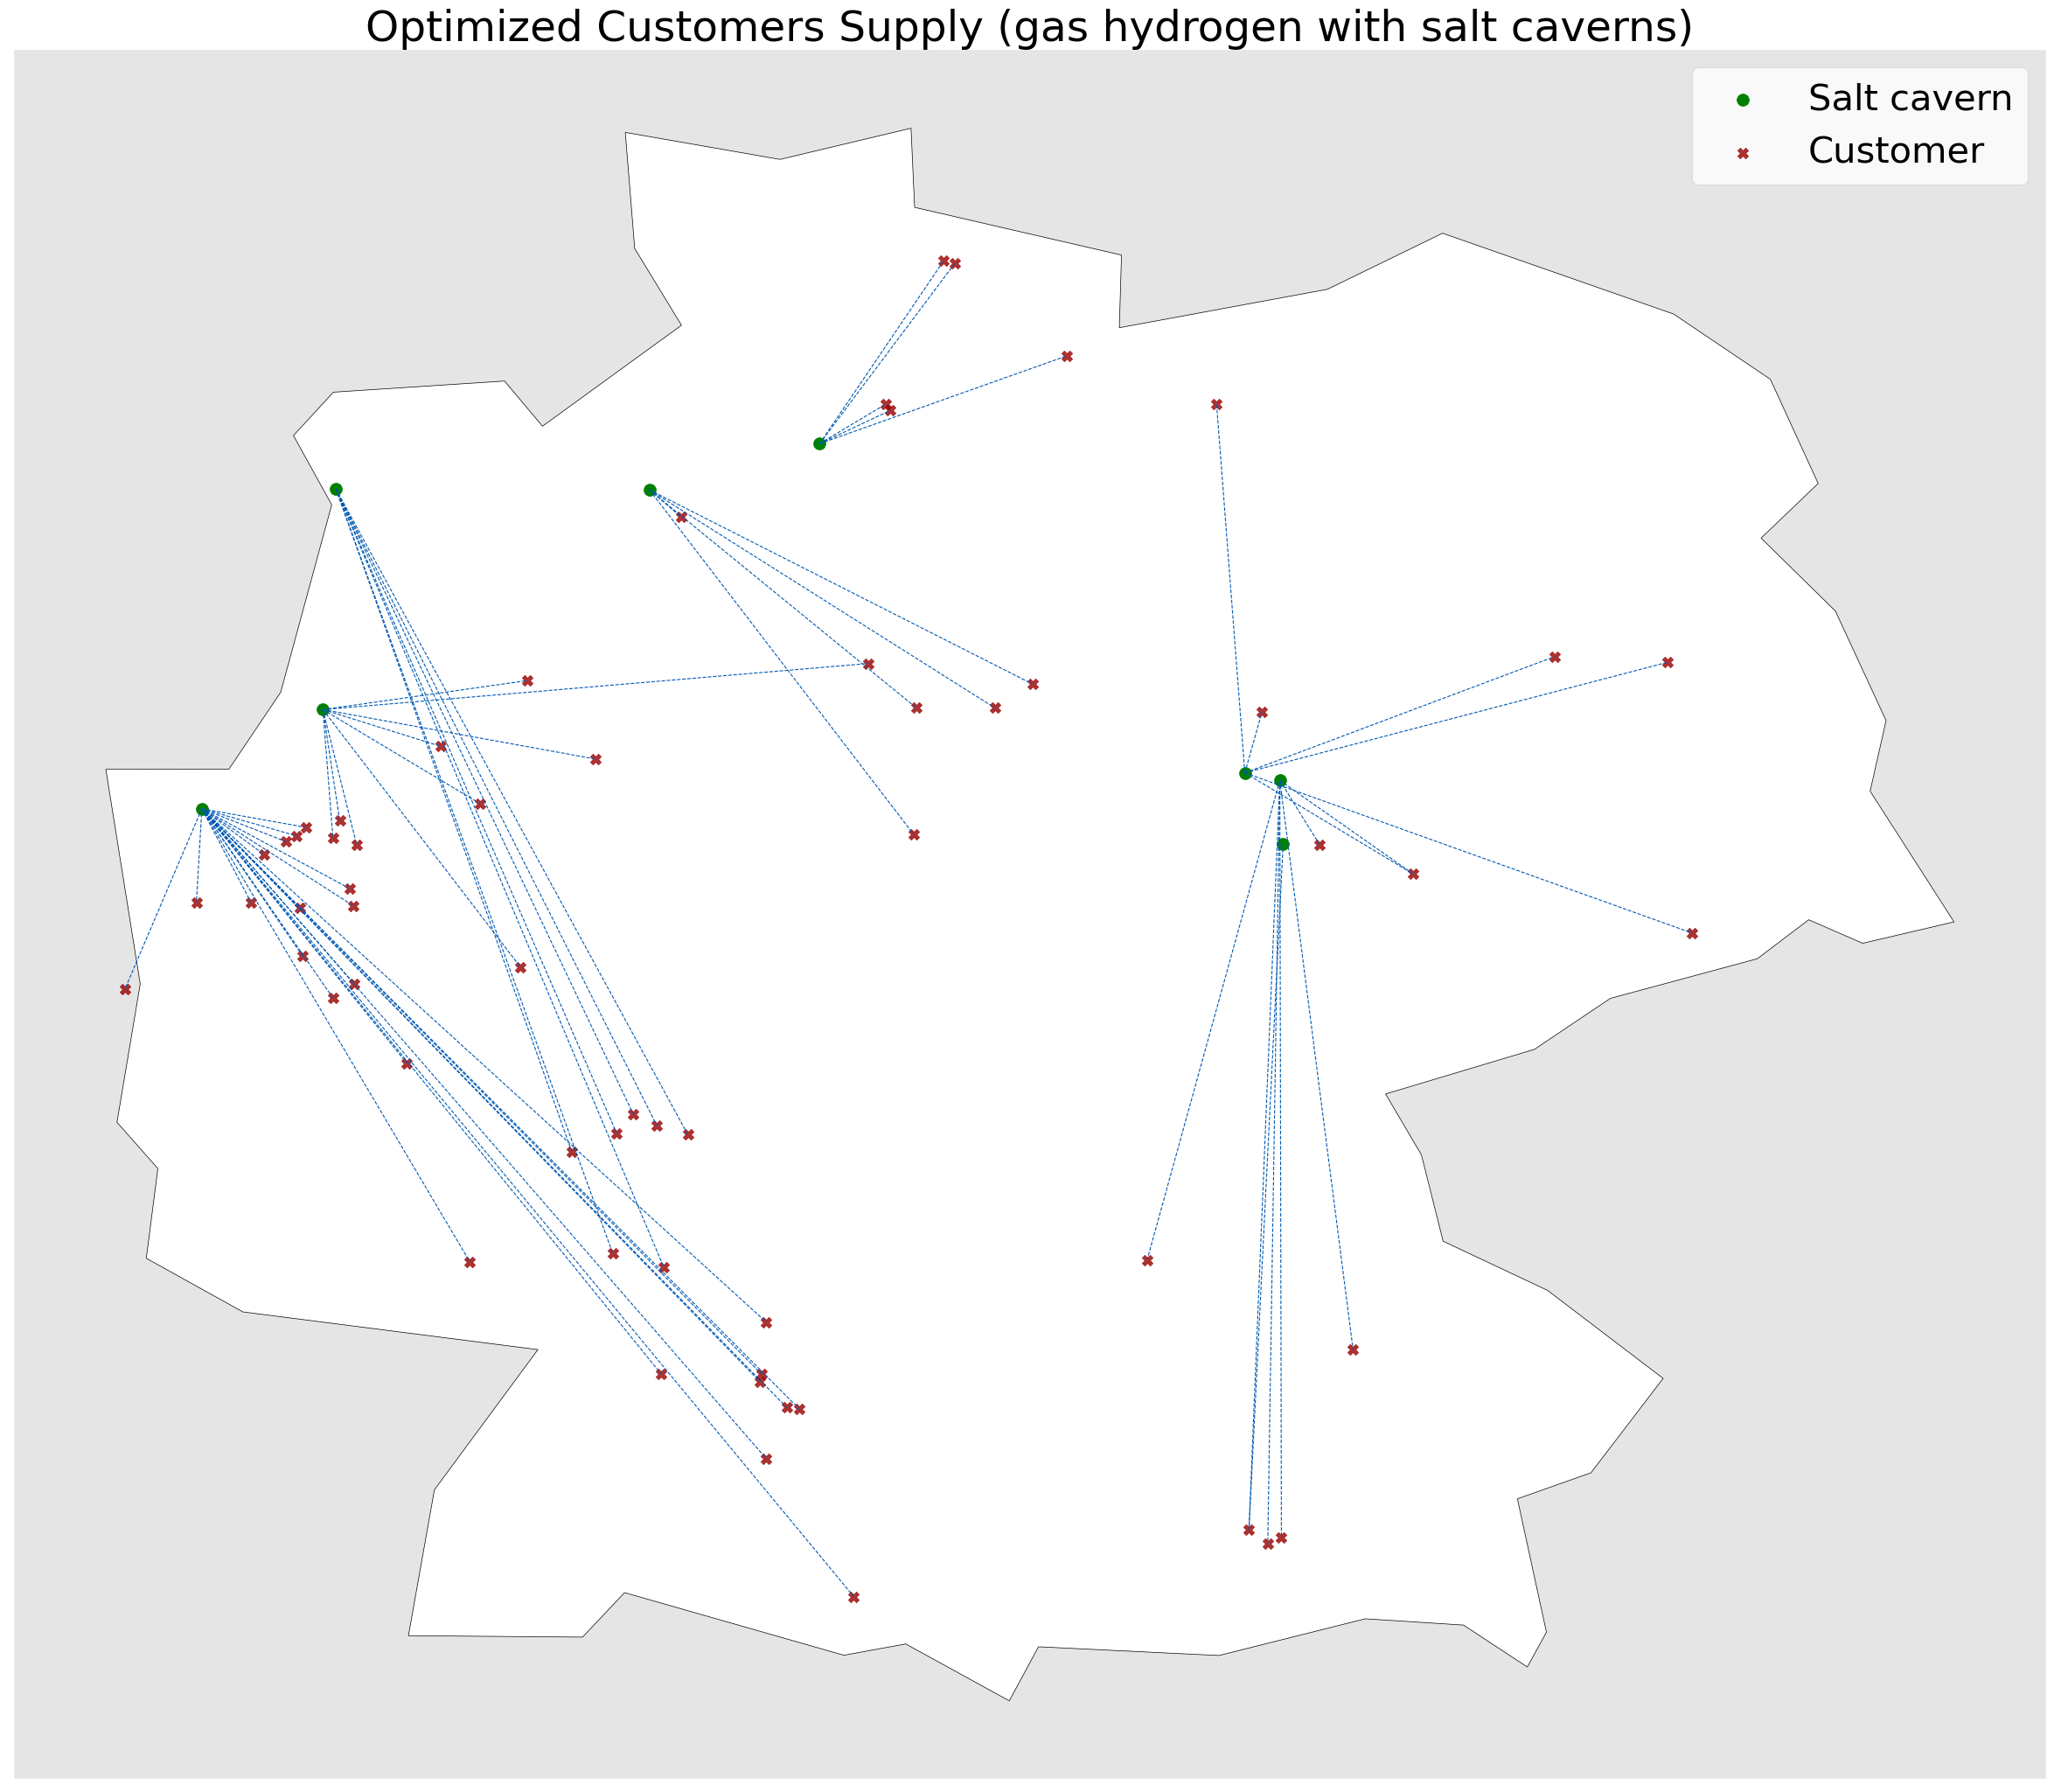

In [17]:
def get_linked_customers(input_warehouse):
    '''
    Find customer ids that are served by the input warehouse.

    Args:
        - input_warehouse: string (example: <Warehouse 21>)
    Out:
        - List of customers ids connected to the warehouse
    '''
    # Initialize empty 
    linked_customers = []

    # Iterate through the xij decision variable
    for (i, j) in served_customer.keys():
        # Filter the input warehouse and positive variable values
        if j == input_warehouse and served_customer[(i, j)].X > 0:
            # Customer is served by the input warehouse
            linked_customers.append(i)

    return linked_customers


# Warehouses to establish
establish = salt_df.loc[salt_df['build_warehouse'] == 'Yes']

# Plot the shape of germany
ax = germany.plot(color='white', edgecolor='black', figsize=(30, 30))

# Plot sites to establish
establish.plot(ax=ax, marker='o', color='green', markersize=100, label='Salt cavern')

# Plot customers
customer_df.plot(ax=ax, marker='X', color='#990000', markersize=80, alpha=0.8, label='Customer')

# For each warehouse to build
for w in establish['salt_id']:
    # Extract list of customers served by the warehouse
    linked_customers = get_linked_customers(w)

    # For each served customer
    for c in linked_customers:
        # Plot connection between warehouse and the served customer
        ax.plot(
            [establish.loc[establish['salt_id'] == w, 'lng'].values[0], customer_df.loc[customer_df['customer_id'] == c, 'lng'].values[0]],
            [establish.loc[establish['salt_id'] == w, 'lat'].values[0], customer_df.loc[customer_df['customer_id'] == c, 'lat'].values[0]],
            linewidth=0.8, linestyle='--', color='#0059b3')

# Add title
plt.title('Optimized Customers Supply (gas hydrogen with salt caverns)', fontsize=35)

# Add legend
plt.legend(facecolor='white', fontsize=30)

# Remove ticks from axis
plt.xticks([])
plt.yticks([])


# Show plot
plt.show()